# Test data loading from different sources

- ARC-AGI
- ARC-AGI-2
- SRaven
- BBH

In [76]:
import os
import sys
import json
import jax
import jax.numpy as jnp
from einops import rearrange
import matplotlib.pyplot as plt

# make SRaven datasets
sys.path.append(os.path.abspath('..'))
from algorithms.hyla.hyla.data.raven import create_raven_datasets

In [ ]:
# Test SRaven datasets

num_features = 8
feature_maxval = 64
grid_size = 3
permute_features = True

with jax.disable_jit(False):
    (ds_train, ds_eval, ds_callback), _ = create_raven_datasets(
        batch_size := 128,
        seq_len := ((9 - 1) * num_features) + num_features,
        num_train=1280, # 128000
        num_test=128,
        num_ood=128,
        num_features=num_features,
        feature_maxval=feature_maxval,
        grid_size=grid_size,
        permute_features=permute_features,
        frac_ood=0.25,
        seed=0,
    )

In [196]:
## notes to self
## from --> Experiment: for step, batch in enumerate(iter(self.train_loader)):
## from --> Experiment:



n_batches = 4
batches = []
di_train = iter(ds_train)
for n, b in zip(range(n_batches), ds_train):
    batches.append(b)

In [197]:
# examine some batches
# raven batches are shape (examples, num_features * 9, feature_maxval)
bx = batches[0].x
by = batches[0].y
print(bx.shape)
print(by.shape)

(128, 72, 64)
(128, 8)


In [198]:
# examine single example
ex = bx[0]
ex = rearrange(ex, '(a b) c -> a b c', a=9, b=8)
# verify one-hot encoding
jnp.unique(ex, return_counts=True)

(Array([0., 1.], dtype=float32), Array([4544,   64], dtype=int32))

In [199]:
ex = ex.argmax(axis=-1)
ex.shape

(9, 8)

In [200]:
data = ex

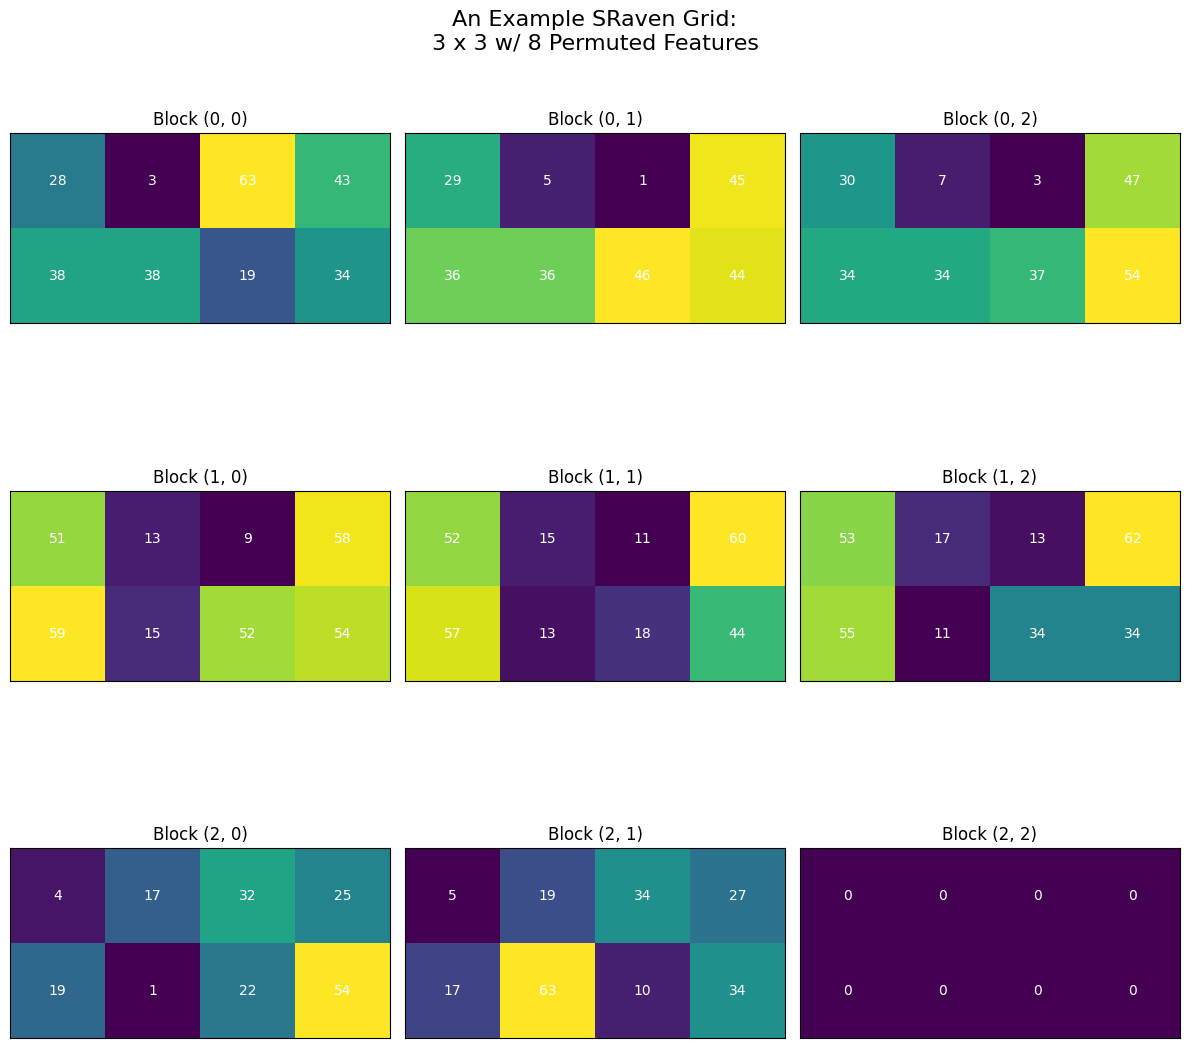

In [201]:
sraven_title = 'An Example SRaven Grid:\n3 x 3 w/ 8 Permuted Features'
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
cmap = plt.cm.viridis

# Loop through the 9 blocks (3×3 grid)
for block_idx in range(9):
    # Calculate row and column in the original array
    block_row = block_idx // 3
    block_col = block_idx % 3
    
    # Extract the corresponding 2×4 sub-array
    # Each block corresponds to one row of the original array
    block_data = data[block_idx].reshape(2, 4)
    
    # Plot this block in its corresponding axis
    im = axes[block_idx].imshow(block_data, cmap=cmap)
    
    # Add text annotations with values
    for i in range(2):
        for j in range(4):
            axes[block_idx].text(j, i, f'{int(block_data[i, j])}', 
                              ha='center', va='center', color='white')
    
    # Add titles to each block
    axes[block_idx].set_title(f'Block ({block_row}, {block_col})')
    
    # Remove ticks for cleaner appearance
    axes[block_idx].set_xticks([])
    axes[block_idx].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{sraven_title}', fontsize=16, y=0.98)
plt.show()

# Load some ARC data -- ensure consistent formatting

In [77]:
# Opening and loading JSON
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Saving JSON
def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)  # indent for pretty printing

In [86]:
# Note: training data visualized here
dataset_name = 'training'

filepath = f'../data/ARC-AGI-2/data/{dataset_name}/'
filenames = os.listdir(filepath)
print(f'ARC-AGI-2 {dataset_name} files:')
print('----------------------')
print('\n'.join(filenames[:10]))
print('...')

ARC-AGI-2 training files:
----------------------
a85d4709.json
c8cbb738.json
8e1813be.json
a699fb00.json
20fb2937.json
5c2c9af4.json
f0afb749.json
44f52bb0.json
94414823.json
23581191.json
...


In [145]:
# FILE FORMAT (one .json file per task):
## -----------------------------
# TASK: { [ { [[]] } ] }
# - 'train': key
# -- examples: [{ [[]] }]
# --- 'input': key
# ---- int[[]]
# --- 'output': key
# ---- int[[]]
# - 'test': key
# --- ibid. ...

index = 0
data = load_json(os.path.join(filepath, filenames[index]))
print(f'Filename:` {filenames[index]}')

Filename:` a85d4709.json


In [146]:
inputs = [data['train'][i]['input'] for i in range(len(data['train']))]
outputs = [data['train'][i]['output'] for i in range(len(data['train']))]
inputs, outputs

([[[5, 0, 0], [0, 5, 0], [5, 0, 0]],
  [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
  [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
  [[0, 0, 5], [0, 5, 0], [5, 0, 0]]],
 [[[2, 2, 2], [4, 4, 4], [2, 2, 2]],
  [[3, 3, 3], [3, 3, 3], [3, 3, 3]],
  [[4, 4, 4], [3, 3, 3], [4, 4, 4]],
  [[3, 3, 3], [4, 4, 4], [2, 2, 2]]])

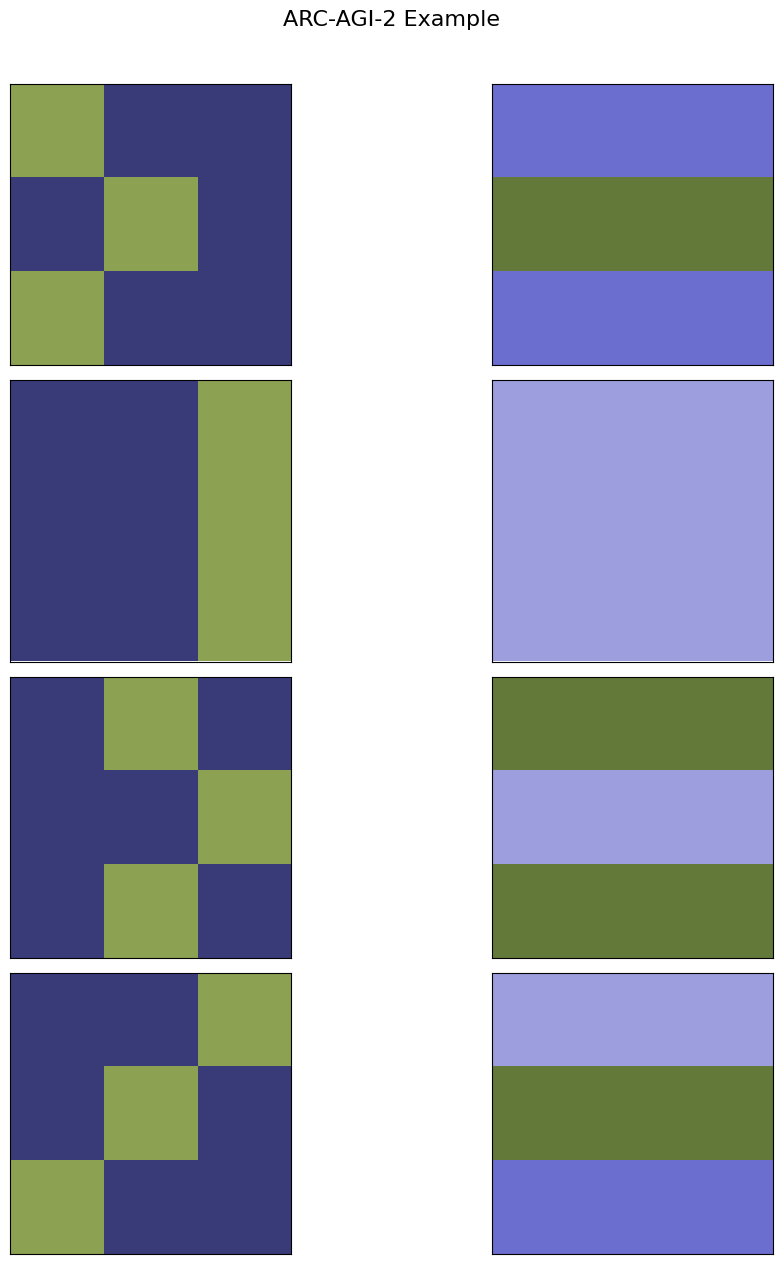

In [147]:
arc2_title = 'ARC-AGI-2 Example'

# global values
vmin = 0
vmax = 20

n_examples = len(data['train'])
fig, axes = plt.subplots(n_examples, 2, figsize=(12, 12))
cmap = plt.cm.tab20b

for r in range(n_examples):
    for c, label in enumerate(['input', 'output']):
        im = axes[r][c].imshow(data['train'][r][label], cmap=cmap, vmin=vmin, vmax=vmax)    
        # Remove ticks for cleaner appearance
        axes[r][c].set_xticks([])
        axes[r][c].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{arc2_title}', fontsize=16, y=1.05)
plt.show()

# Data Augmentation Primitives + Pretraining

Primitives:
- random collection of random colors
- row-wise and column-wise independent translations
- multi-column and multi-row grouped translations (independent between groups)
- rotations
- reflections
- rescalings

In [153]:
from jax import random

key = random.key(0)

In [178]:
def random_grid(key, size_x=None, size_y=None, max_value=10, size_max=30, sparsity=0.8):
    """ Create a single random grid.
    Args:
        key: jax random key
        size_x: x dimension of grid
        size_y: y dimension of grid
        max_value: maximum value in grid
        sparsity: fraction of grid to be zero
    """
    key1, key2, key3 = random.split(key, 3)
    # handle optional size_x and size_y
    if not size_x and not size_y:
        size_x, size_y = random.randint(key1, (2,), 1, size_max)
    elif size_x and not size_y:
        size_y = size_x
    elif size_y and not size_x:
        size_x = size_y
    grid = random.randint(key2, (size_x, size_y), 0, max_value)
    # apply sparsity
    mask = random.uniform(key3, grid.shape) < sparsity
    grid = jnp.where(mask, 0, grid)
    return grid

In [202]:
key = key, fn_key = random.split(key)
rg = random_grid(fn_key)

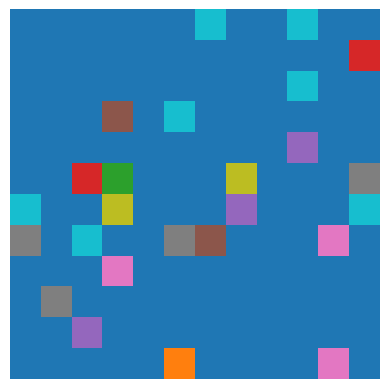

In [203]:
cmap = plt.cm.tab10
plt.imshow(rg, cmap=cmap)
plt.axis('off')
plt.show()

## TODO:

- Essential: ensure these operate on a batch of examples
  - This may require that we separate the translation from its application
  - This way, we form "tasks" of demonstrated IO pairs.
- Less important, still good: make these all operate on huge arrays that can be batched for extreme efficiency increase

In [ ]:
# grid functions
def _permute(key, grid, axis):
    """ Permute a grid along a certain axis.
    Args:
        key: jax random key
        grid: grid to permute
    """
    key1, key2 = random.split(key, 2)
    perm = random.permutation(key1, grid.shape[axis])
    return grid[perm]

def permute_rows(key, grid):
    """ Permute rows of a grid.
    Args:
        key: jax random key
        grid: grid to permute
    """
    return _permute(key, grid, 0)

def permute_columns(key, grid):
    """ Permute columns of a grid.
    Args:
        key: jax random key
        grid: grid to permute
    """
    return _permute(key, grid, 1)

def permute_colors(key, grid):
    """ Permute colors of a grid.
    Args:
        key: jax random key
        grid: grid to permute
    """
    perm = random.permutation(key, grid.shape[1])
    return grid[:, perm]

def rotate(key, grid):
    key1, key2 = random.split(key)
    n_rotations = random.randint(key1, (1,), 0, 4)
    return jnp.rot90(grid, k=n_rotations)

def flip(key, grid, axis):
    return jnp.flip(grid, axis=axis)

def tranpose(key, grid):
    return jnp.transpose(grid)

def translate(key, grid, max_shift=None, roll=True):
    """ If roll is True, roll the grid.
        Otherwise, the grid will be filled with zeros at the trailing edge.
    """
    if not max_shift:
        max_shift = grid.shape[0] // 2
    key1, key2 = random.split(key)
    dx = random.randint(key1, (1,), -max_shift, max_shift + 1)
    dy = random.randint(key2, (1,), -max_shift, max_shift + 1)
    grid = jnp.roll(grid, shift=(dx, dy), axis=(0, 1))
    # Create a mask to zero out the wrapped elements
    if not roll:
        mask = jnp.ones_like(grid)
        if dx > 0:
            mask = mask.at[:, :dx].set(0)  # Zero out left columns
        elif dx < 0:
            mask = mask.at[:, dx:].set(0)  # Zero out right columns
        if dy > 0:
            mask = mask.at[:dy, :].set(0)  # Zero out top rows
        elif dy < 0:
            mask = mask.at[dy:, :].set(0)  # Zero out bottom rows
        grid = grid * mask
    return grid

def make_shifts(key, max_shift, size):
    return random.randint(key, (size,), -max_shift, max_shift + 1)

def shift_line(dim, shift):
    """Shift a single row / column by the given amount."""
    return jnp.roll(dim, shift, axis=0)

def shift_dims(grid, shifts, axis=0):
    """
    Shift each column in the array by the corresponding amount in shifts.
    
    Args:
        x: Input array of shape (height, width, ...)
        shifts: 1D array of integers specifying how much to shift each column
               Positive values shift down, negative values shift up
               
    Returns:
        Shifted array of the same shape as x
    """
    # Transpose to get columns as the first dimension
    grid_t = jnp.transpose(grid, (1, 0) + tuple(range(2, len(grid.shape))))
    grid_st = jax.vmap(shift_line, in_axes=(0, 0))(grid_t, shifts)
    # Transpose back to original shape
    grid = jnp.transpose(grid_st, (1, 0) + tuple(range(2, len(grid.shape))))
    return grid

def patch(key, grid, patch_x=None, patch_y=None, patch_value=0):
    """ Apply a patch to a grid. Replaces all values
        in the patch with patch_value.
    """
    key1, key2 = random.split(key)
    size_x, size_y = grid.shape
    # handle optional patch_x and patch_y
    if not patch_x and not patch_y:
        patch_x, patch_y = random.randint(key1, (2,), 0, size_x)
    elif patch_x and not patch_y:
        patch_y = patch_x
    elif patch_y and not patch_x:
        patch_x = patch_y
    grid = grid.at[patch_x:patch_x + size_x, patch_y:patch_y + size_y].set(patch_value)
    return grid

def rescale(key, grid, scale_factor=None, max_scale_factor=6):
    """Rescale a grid by a certain factor using JAX operations.
    
    Args:
        key: jax random key
        grid: grid to rescale
        scale_factor: scale factor (if None, randomly chosen)
        max_scale_factor: maximum scale factor for random selection
        
    Returns:
        Upsampled grid
    """
    # Generate random scale factor if not provided
    if scale_factor is None:
        scale_factor = jax.random.randint(key, (1,), 1, max_scale_factor + 1)[0]
    size_x, size_y = grid.shape
    new_size_x = int(size_x * scale_factor)
    new_size_y = int(size_y * scale_factor)
    i_indices = jnp.arange(new_size_x)
    j_indices = jnp.arange(new_size_y)
    x_indices = (i_indices // scale_factor).astype(jnp.int32)
    y_indices = (j_indices // scale_factor).astype(jnp.int32)
    # Create meshgrid of coordinates
    X, Y = jnp.meshgrid(x_indices, y_indices, indexing='ij')
    new_grid = grid[X, Y]
    return new_grid

def crop(key, grid, crop_x, crop_y, ul_corner_x, ul_corner_y):
    """ Crop a grid by a certain amount.
    Args:
        key: jax random key
        grid: grid to crop
        crop_x: amount to crop in x direction
        crop_y: amount to crop in y direction
        ul_corner_x: upper left corner x coordinate
        ul_corner_y: upper left corner y coordinate
    """
    size_x, size_y = grid.shape
    grid = grid.at[ul_corner_x:ul_corner_x + size_x - crop_x, ul_corner_y:ul_corner_y + size_y - crop_y].set(0)
    return grid